In [1]:
import struct
from utils.Auger.SD import *

# see CDAS git /Raid/src/Utils/CL/cl_msg_unknown_pack.h
def read_package(f) -> dict:

    convert = lambda d: [struct.unpack('d', d[i:i+8])[0] for i in range(0, len(d), 8)]
    # package = {}

    # pack Header
    LsId = int.from_bytes(f.read(2), byteorder='little')
    n_packs = int.from_bytes(f.read(2), byteorder='little')
    timestamp_sec = int.from_bytes(f.read(4), byteorder='little')
    timestamp_nsec = int.from_bytes(f.read(4), byteorder='little')
    total_size = int.from_bytes(f.read(4), byteorder='little')
    rv = LsId, None

    for i in range(n_packs):

        # header i
        type = int.from_bytes(f.read(4), byteorder='little')
        version = int.from_bytes(f.read(4), byteorder='little')
        size = int.from_bytes(f.read(4), byteorder='little')
        data = f.read(size)


        # package[str(i)] = {'type': type,
        #                 'version': version,
        #                 'size': size,
        #                 'data': data}

        # only return the data we're interested in
        if type == 8 and version == 2:
            rv = LsId, convert(data)
    
    return rv

14:07:22 (   +1.6s) [INFO   ] -- import logging
14:07:22 (   +44ms) [INFO   ] -- import numpy as np
14:07:22 (    +4ms) [INFO   ] -- import uncertainties
14:07:23 (  +184ms) [INFO   ] -- import pandas as pd
14:07:23 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
14:07:23 (    +1ms) [INFO   ] -- import binaries.tools as tools
14:07:23 (  +512ms) [INFO   ] -- import matplotlib.pyplot as plt
14:07:23 (   +23ms) [INFO   ] -- import seaborn as so
14:07:23 (    +2ms) [INFO   ] -- import plotting.tools as plot
14:07:23 (    +6ms) [DEBUG  ] -- font size set to 9.5
14:07:23 (    +0ms) [DEBUG  ] -- label size set to 13.0
14:07:23 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
14:07:23 (    +0ms) [DEBUG  ] -- markersize set to 2.0
14:07:23 (    +1ms) [DEBUG  ] -- usetex set to False


In [2]:

# days = [6, 7, 8]
days = [9]
official_daq = []
for day in days:
    try:
        with open(f'/home/filip/Desktop/unread_packages/monit_2024_12_{day:02}.packs.nobackup', 'rb') as f:
            while f.read(8) == b'!monit!!':
                official_daq.append(read_package(f))

    except FileNotFoundError as e: print(e)

with open(f'/home/filip/Desktop/unread_packages/monit_2024_12_{days[-1] + 1:02}.packs.nobackup', 'rb') as f:
    while f.read(8) == b'!monit!!':
        official_daq.append(read_package(f))

monit = Monit(2024, 12, days)

14:07:23 (  +142ms) [INFO   ] -- received 3 file(s) as input
14:07:23 (  +190ms) [INFO   ] -- View monit keys with self.keys()


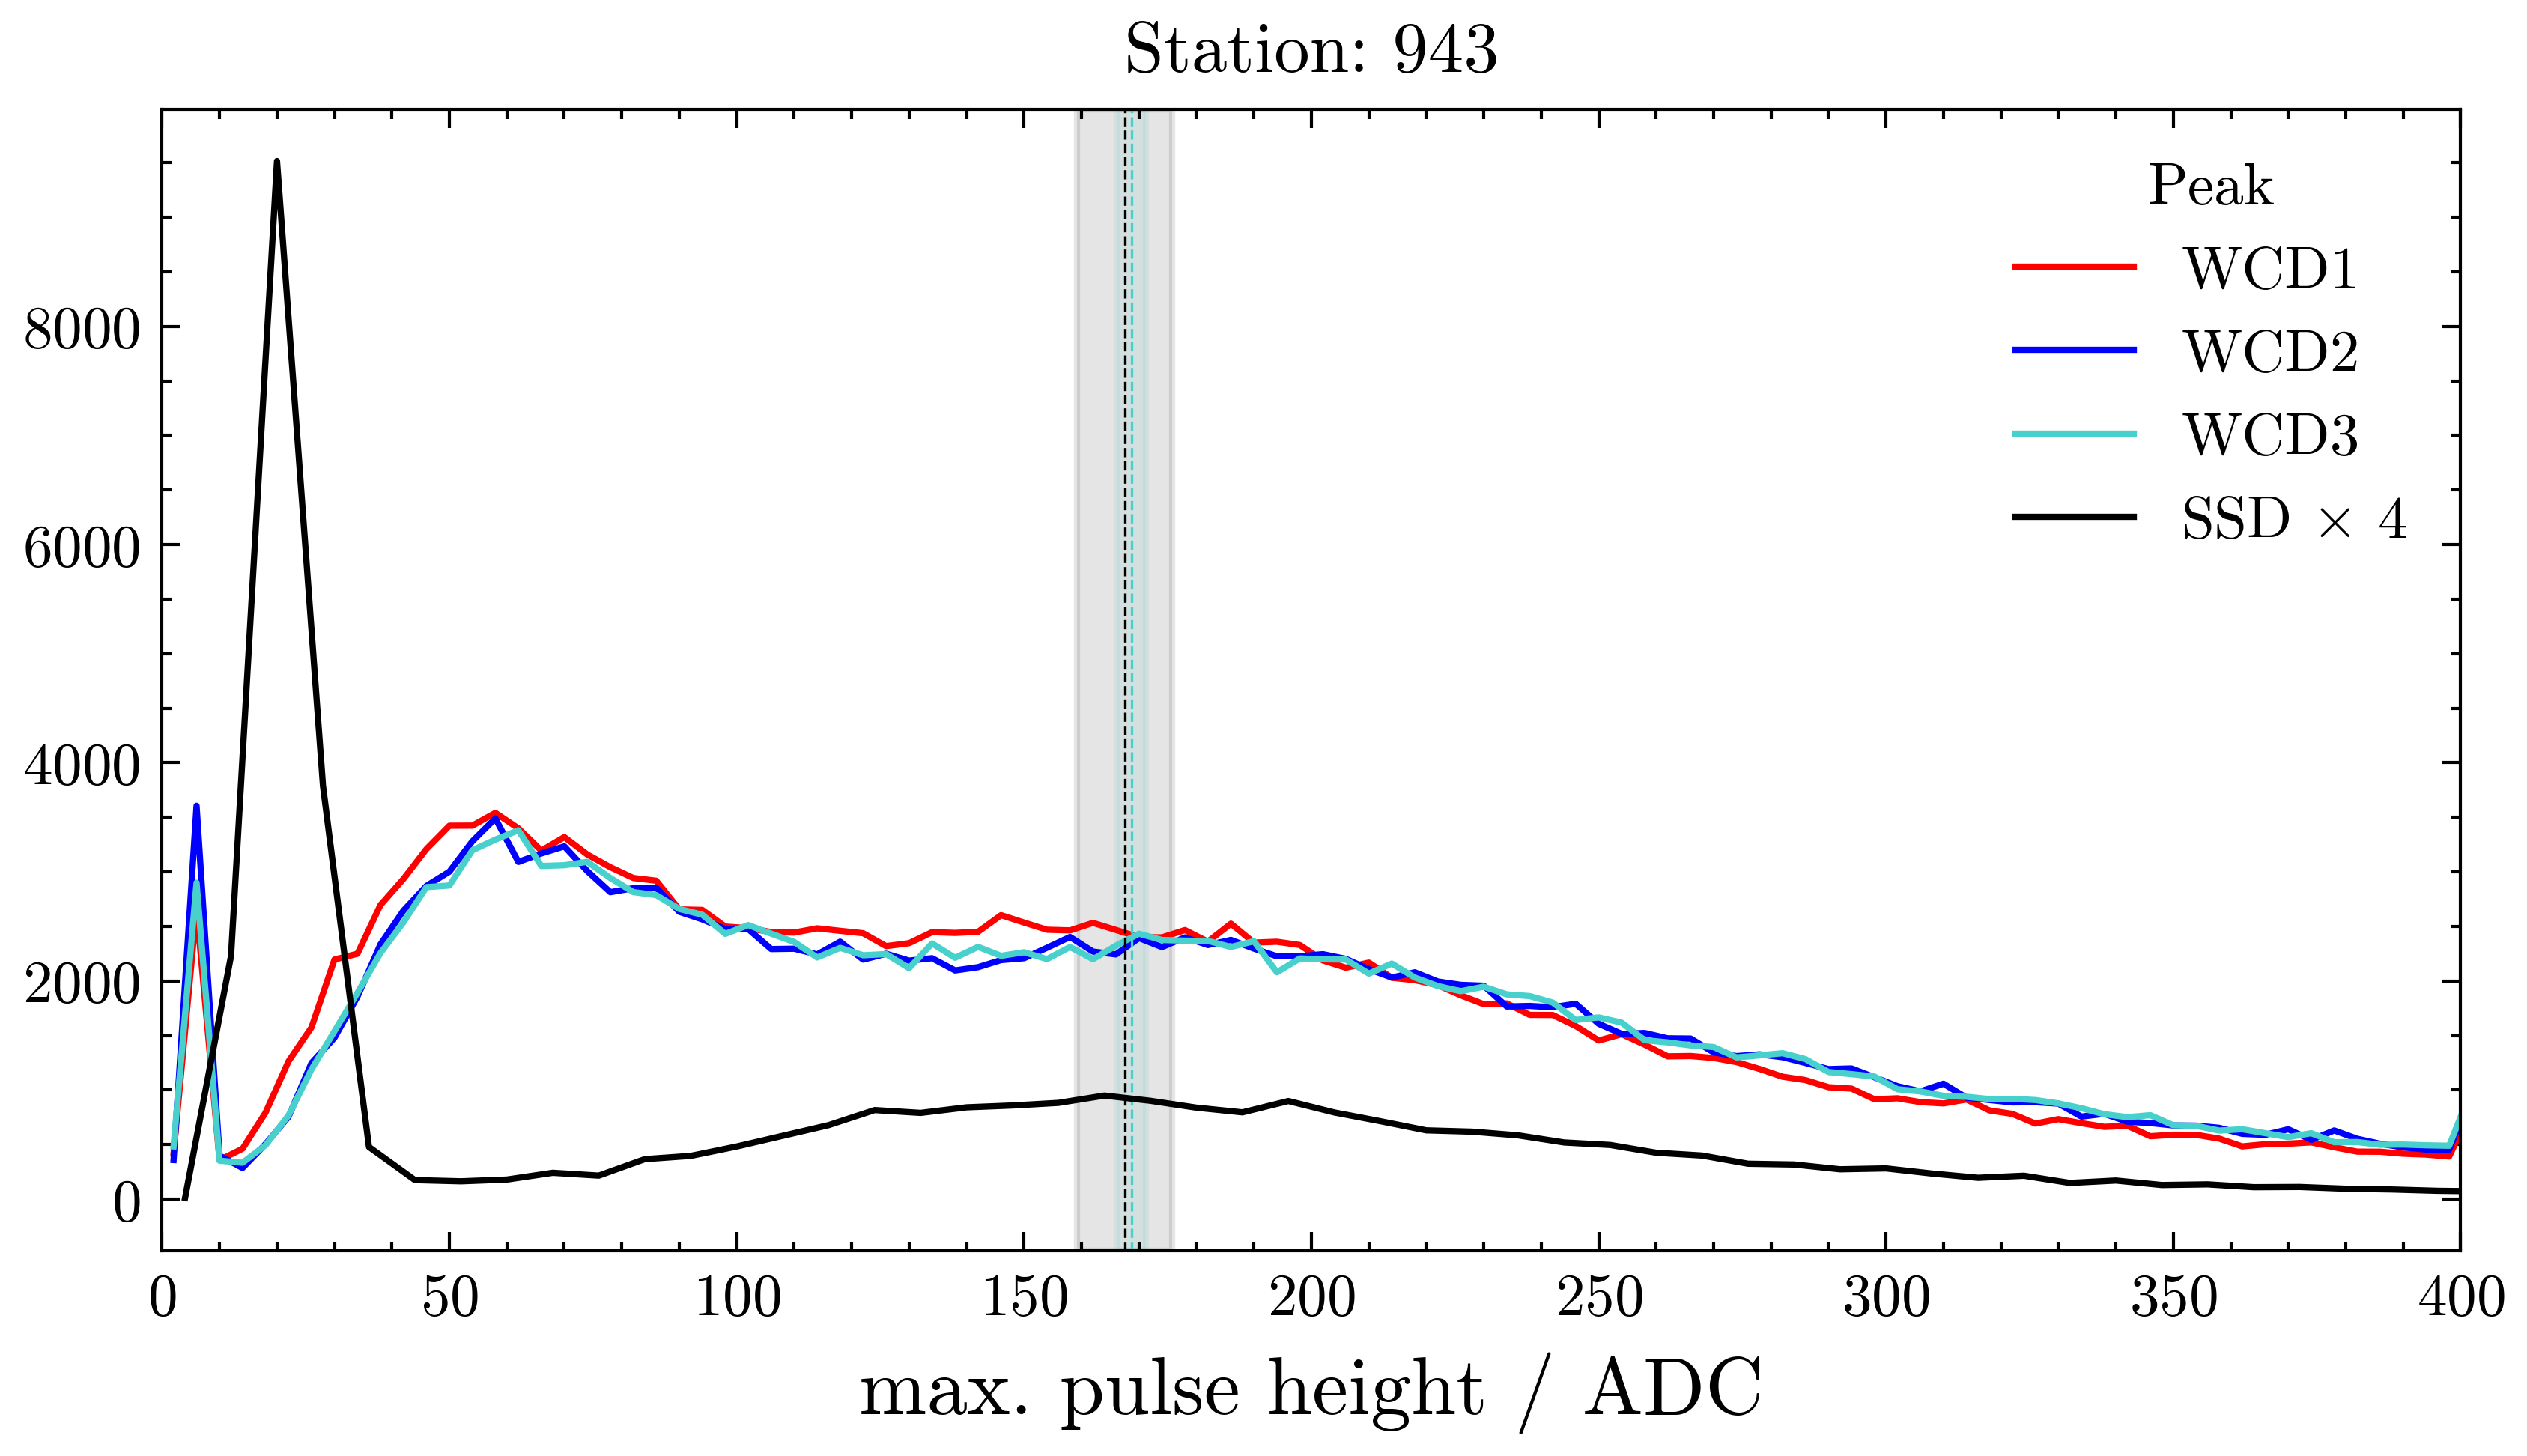

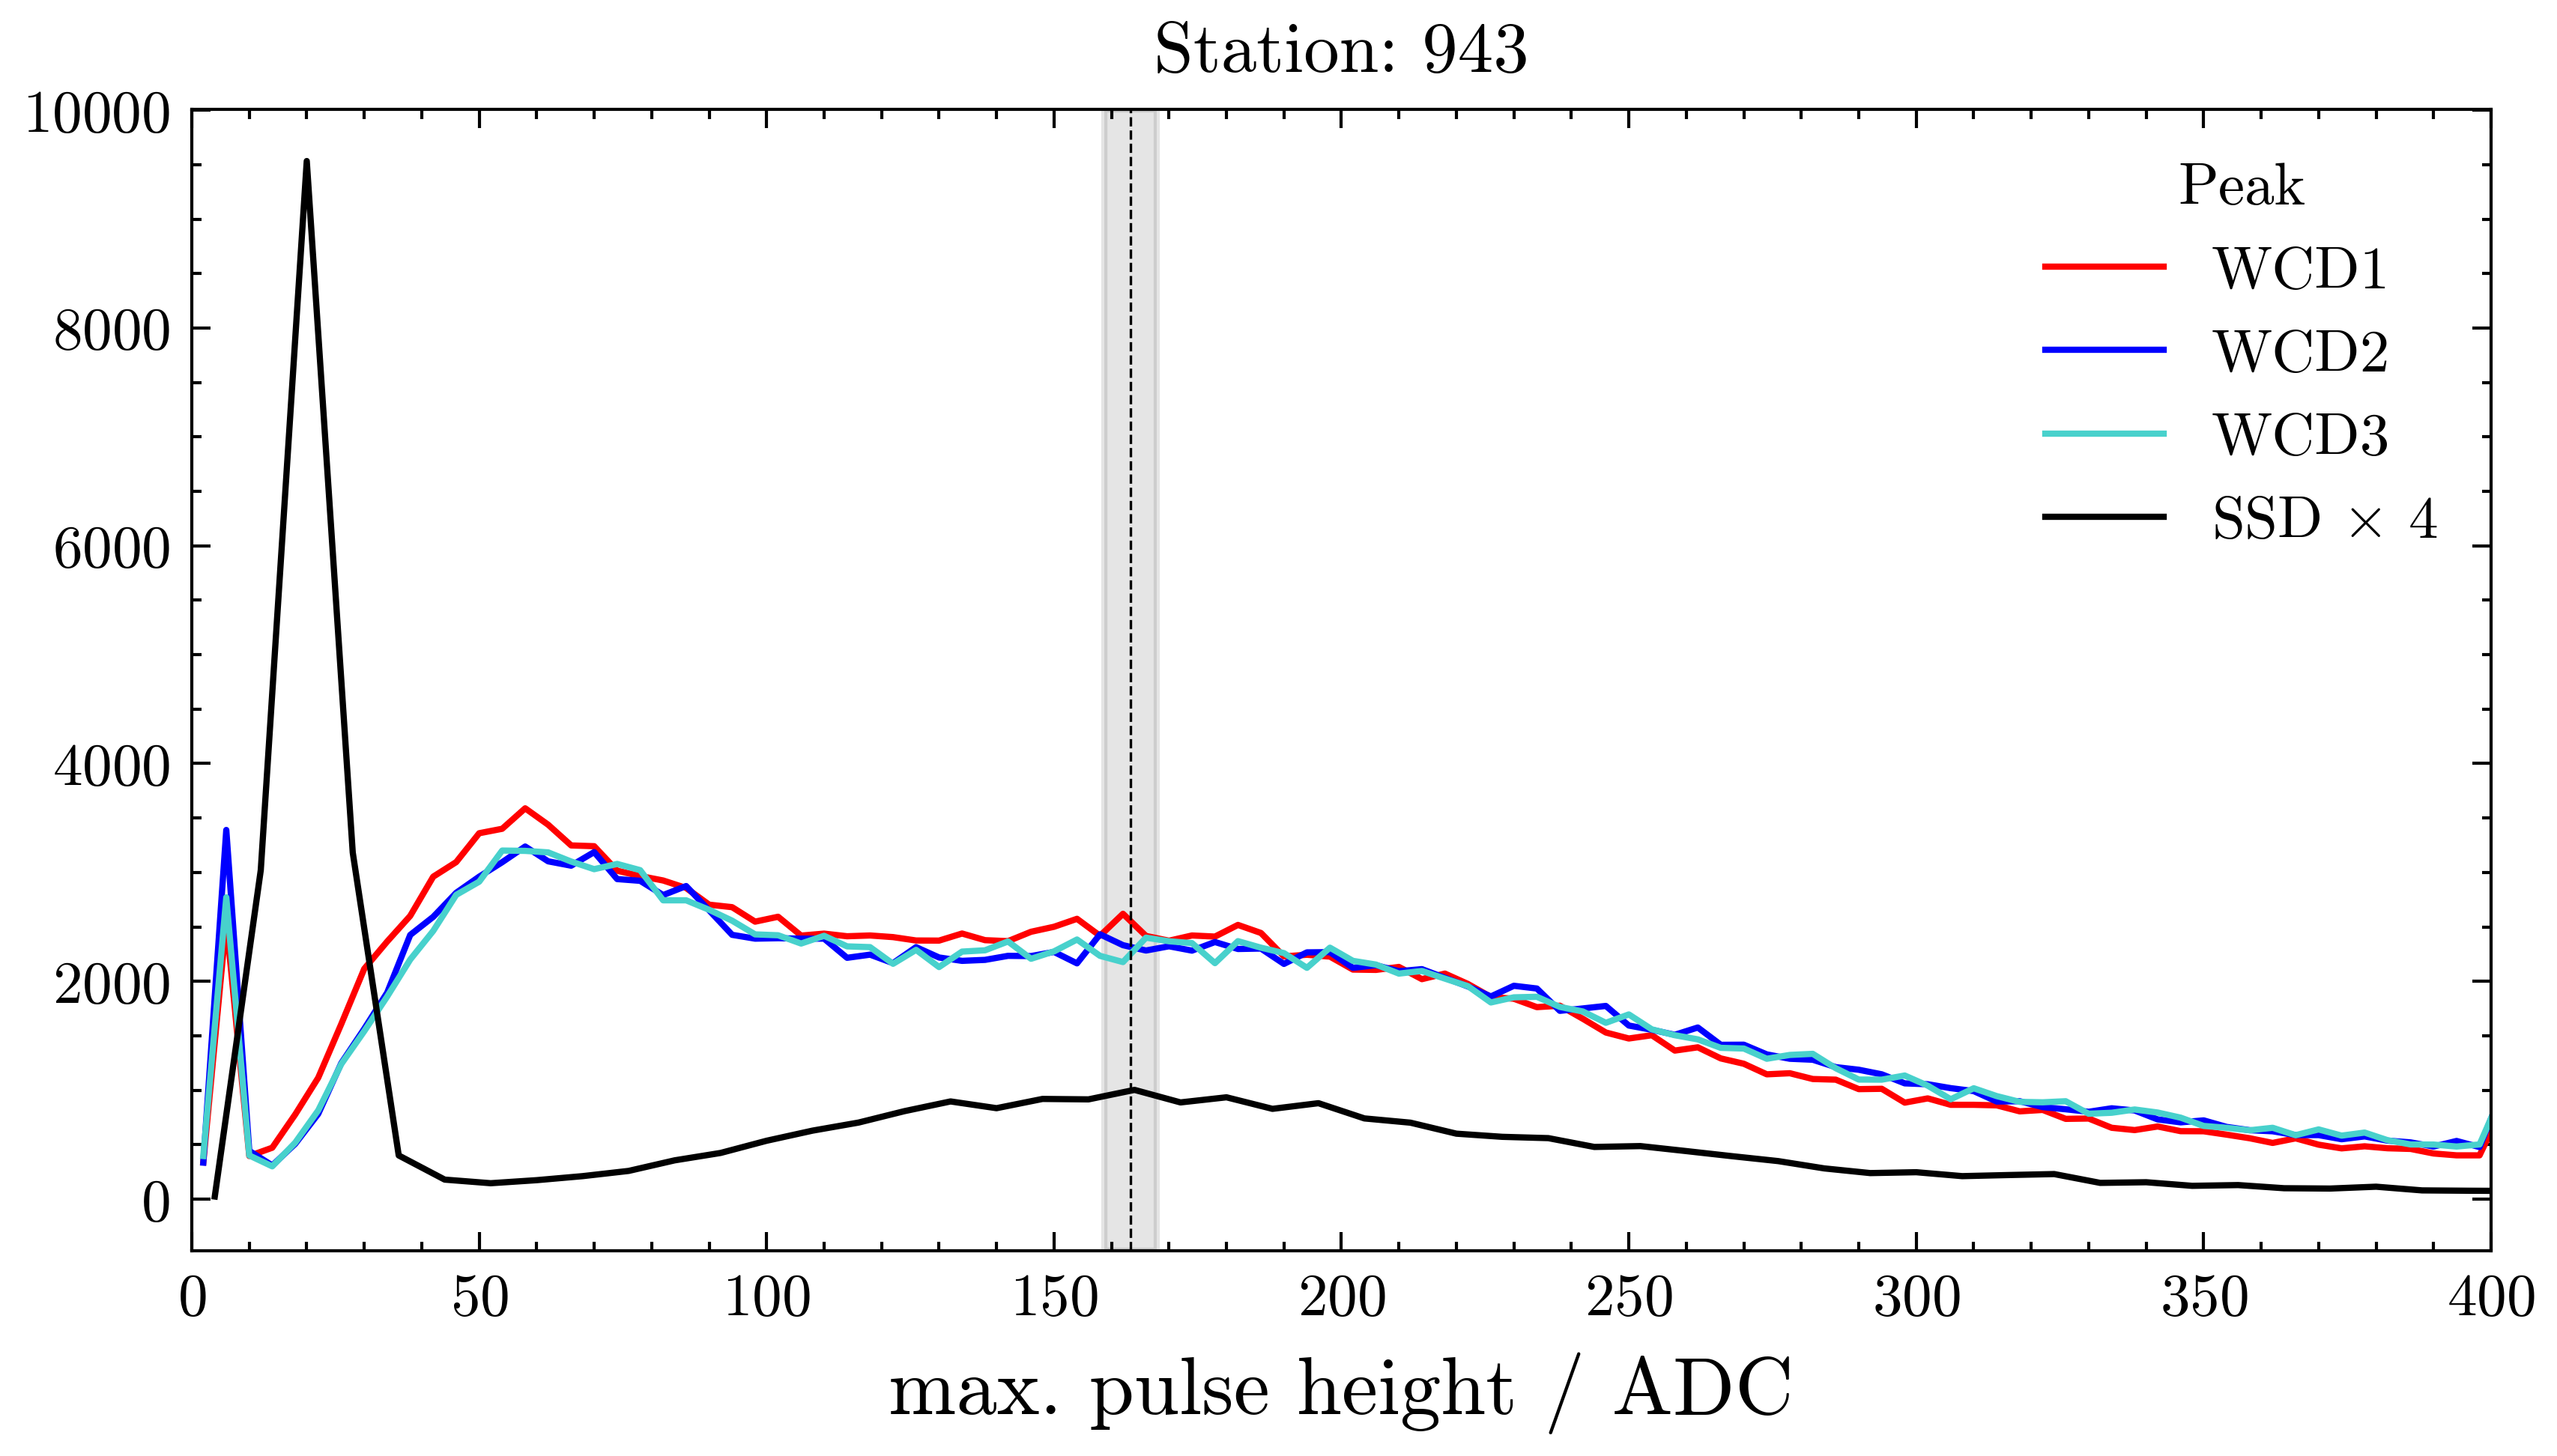

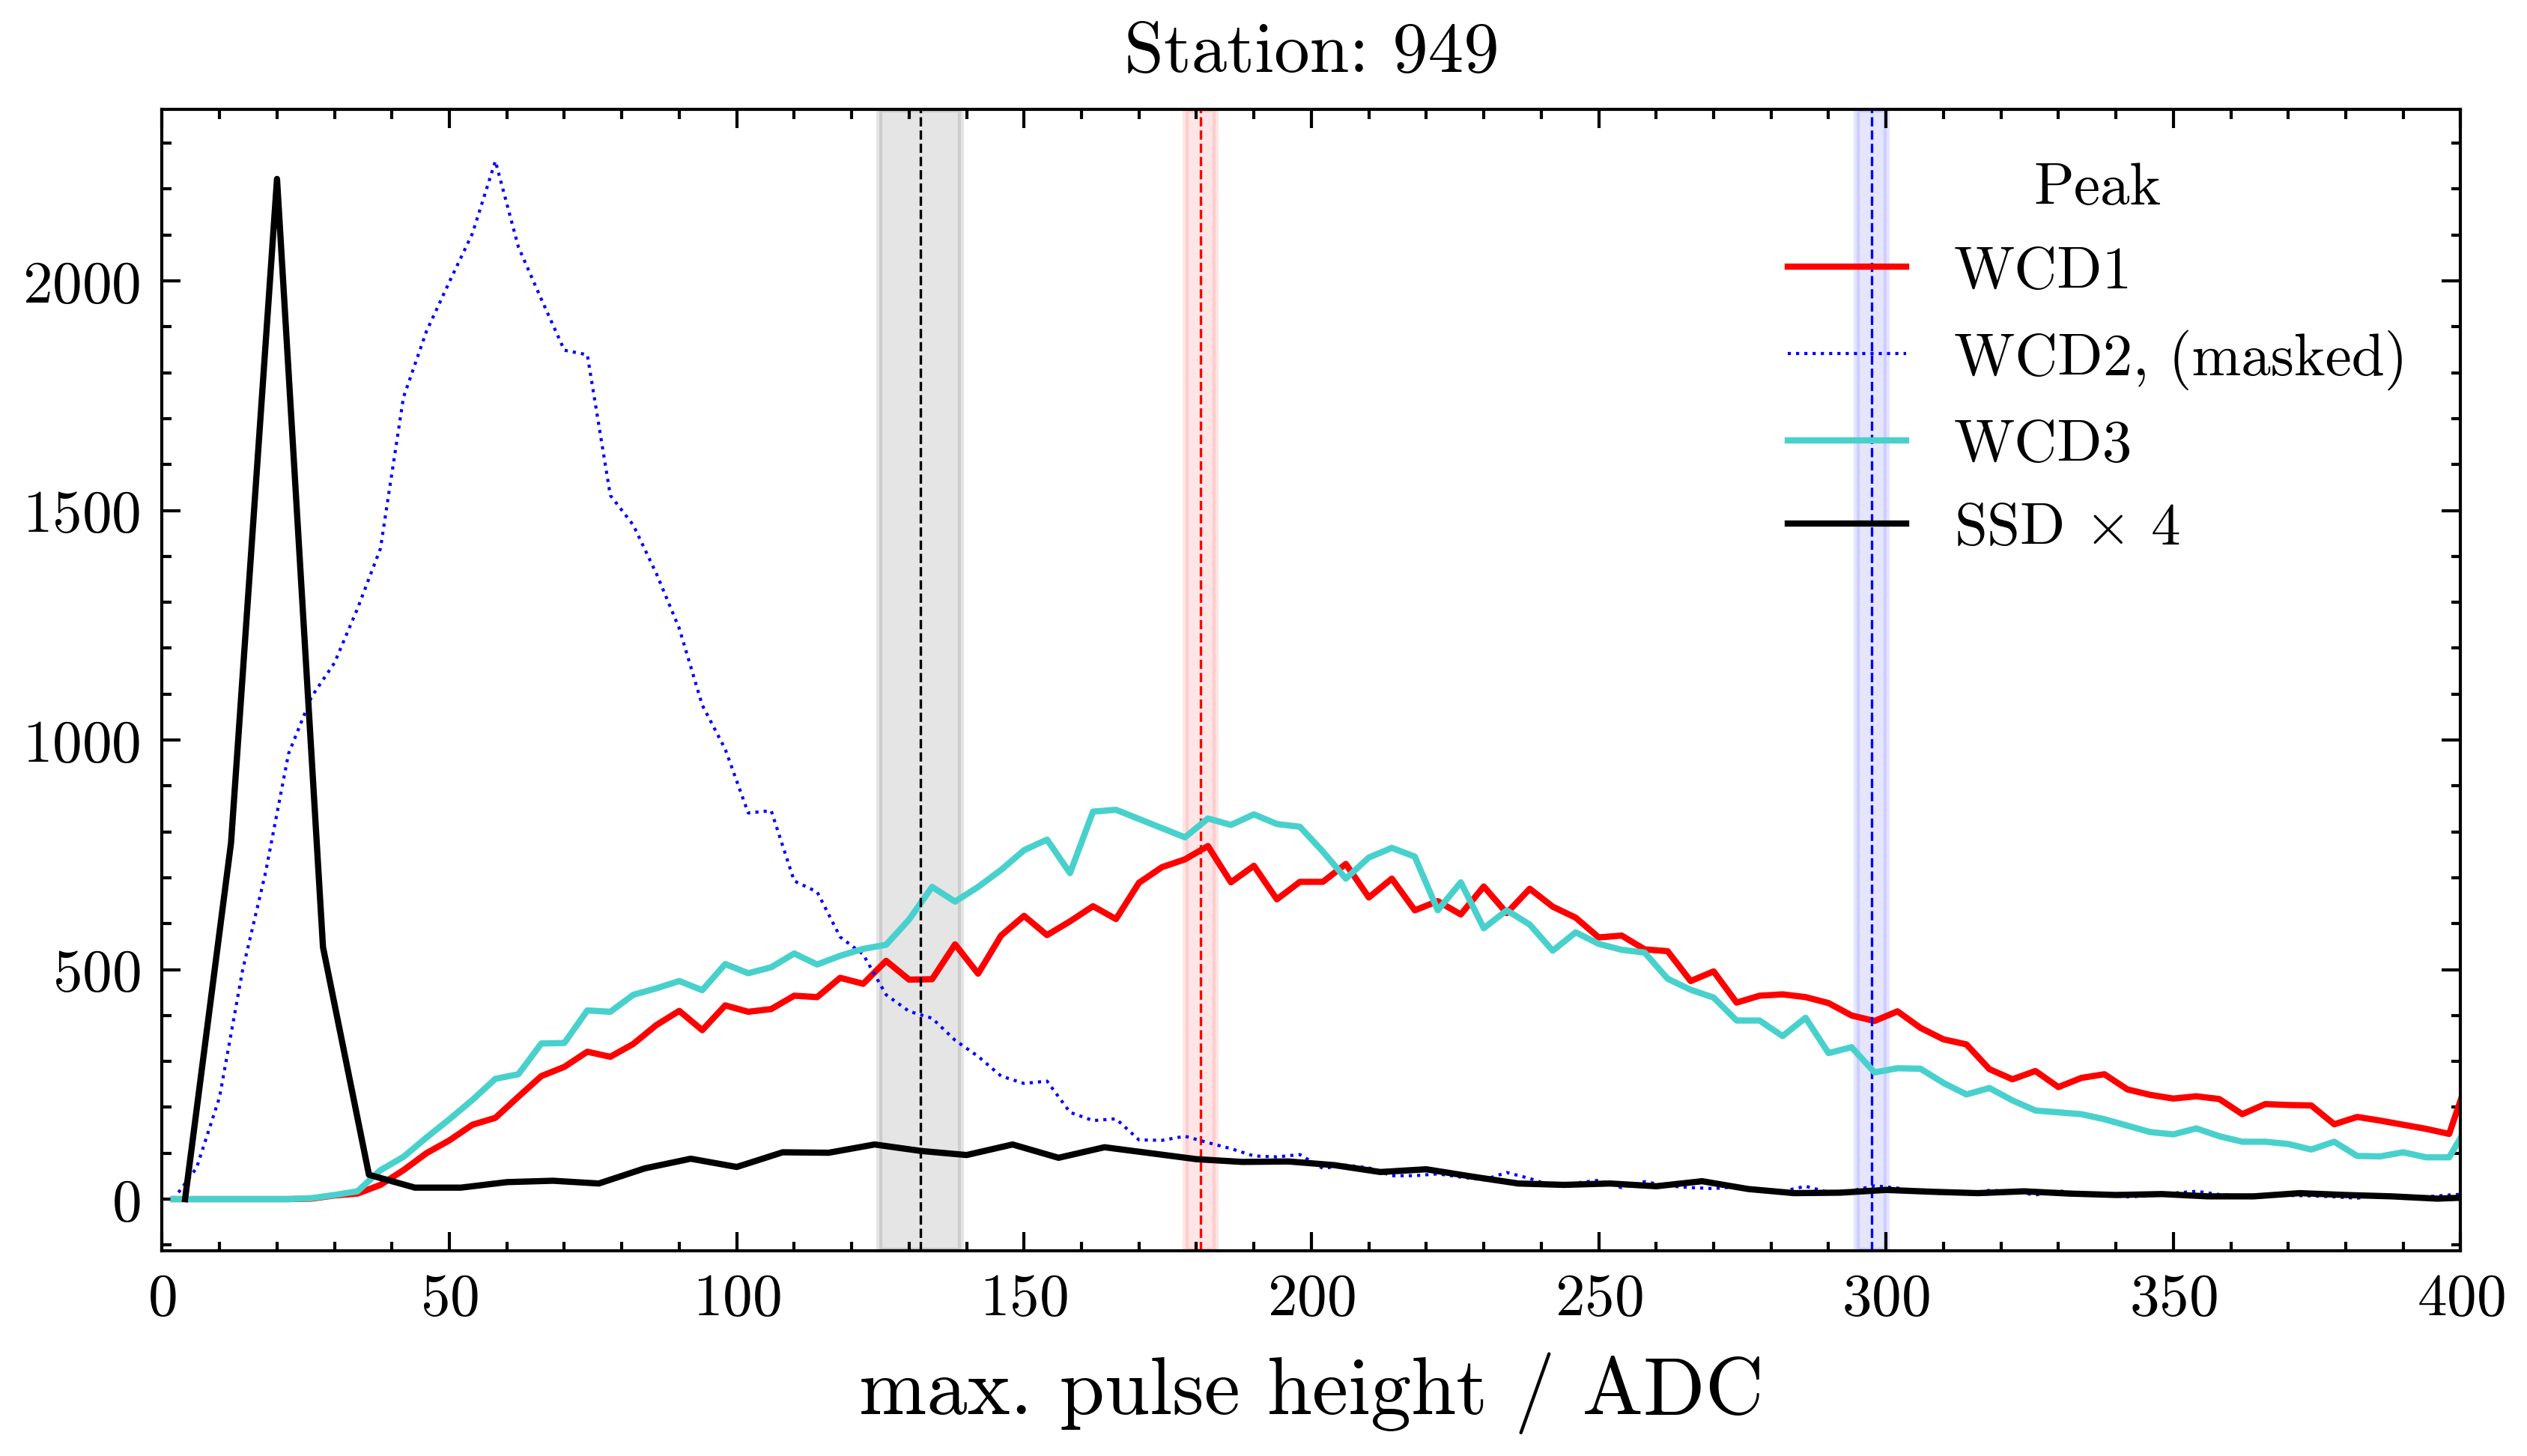

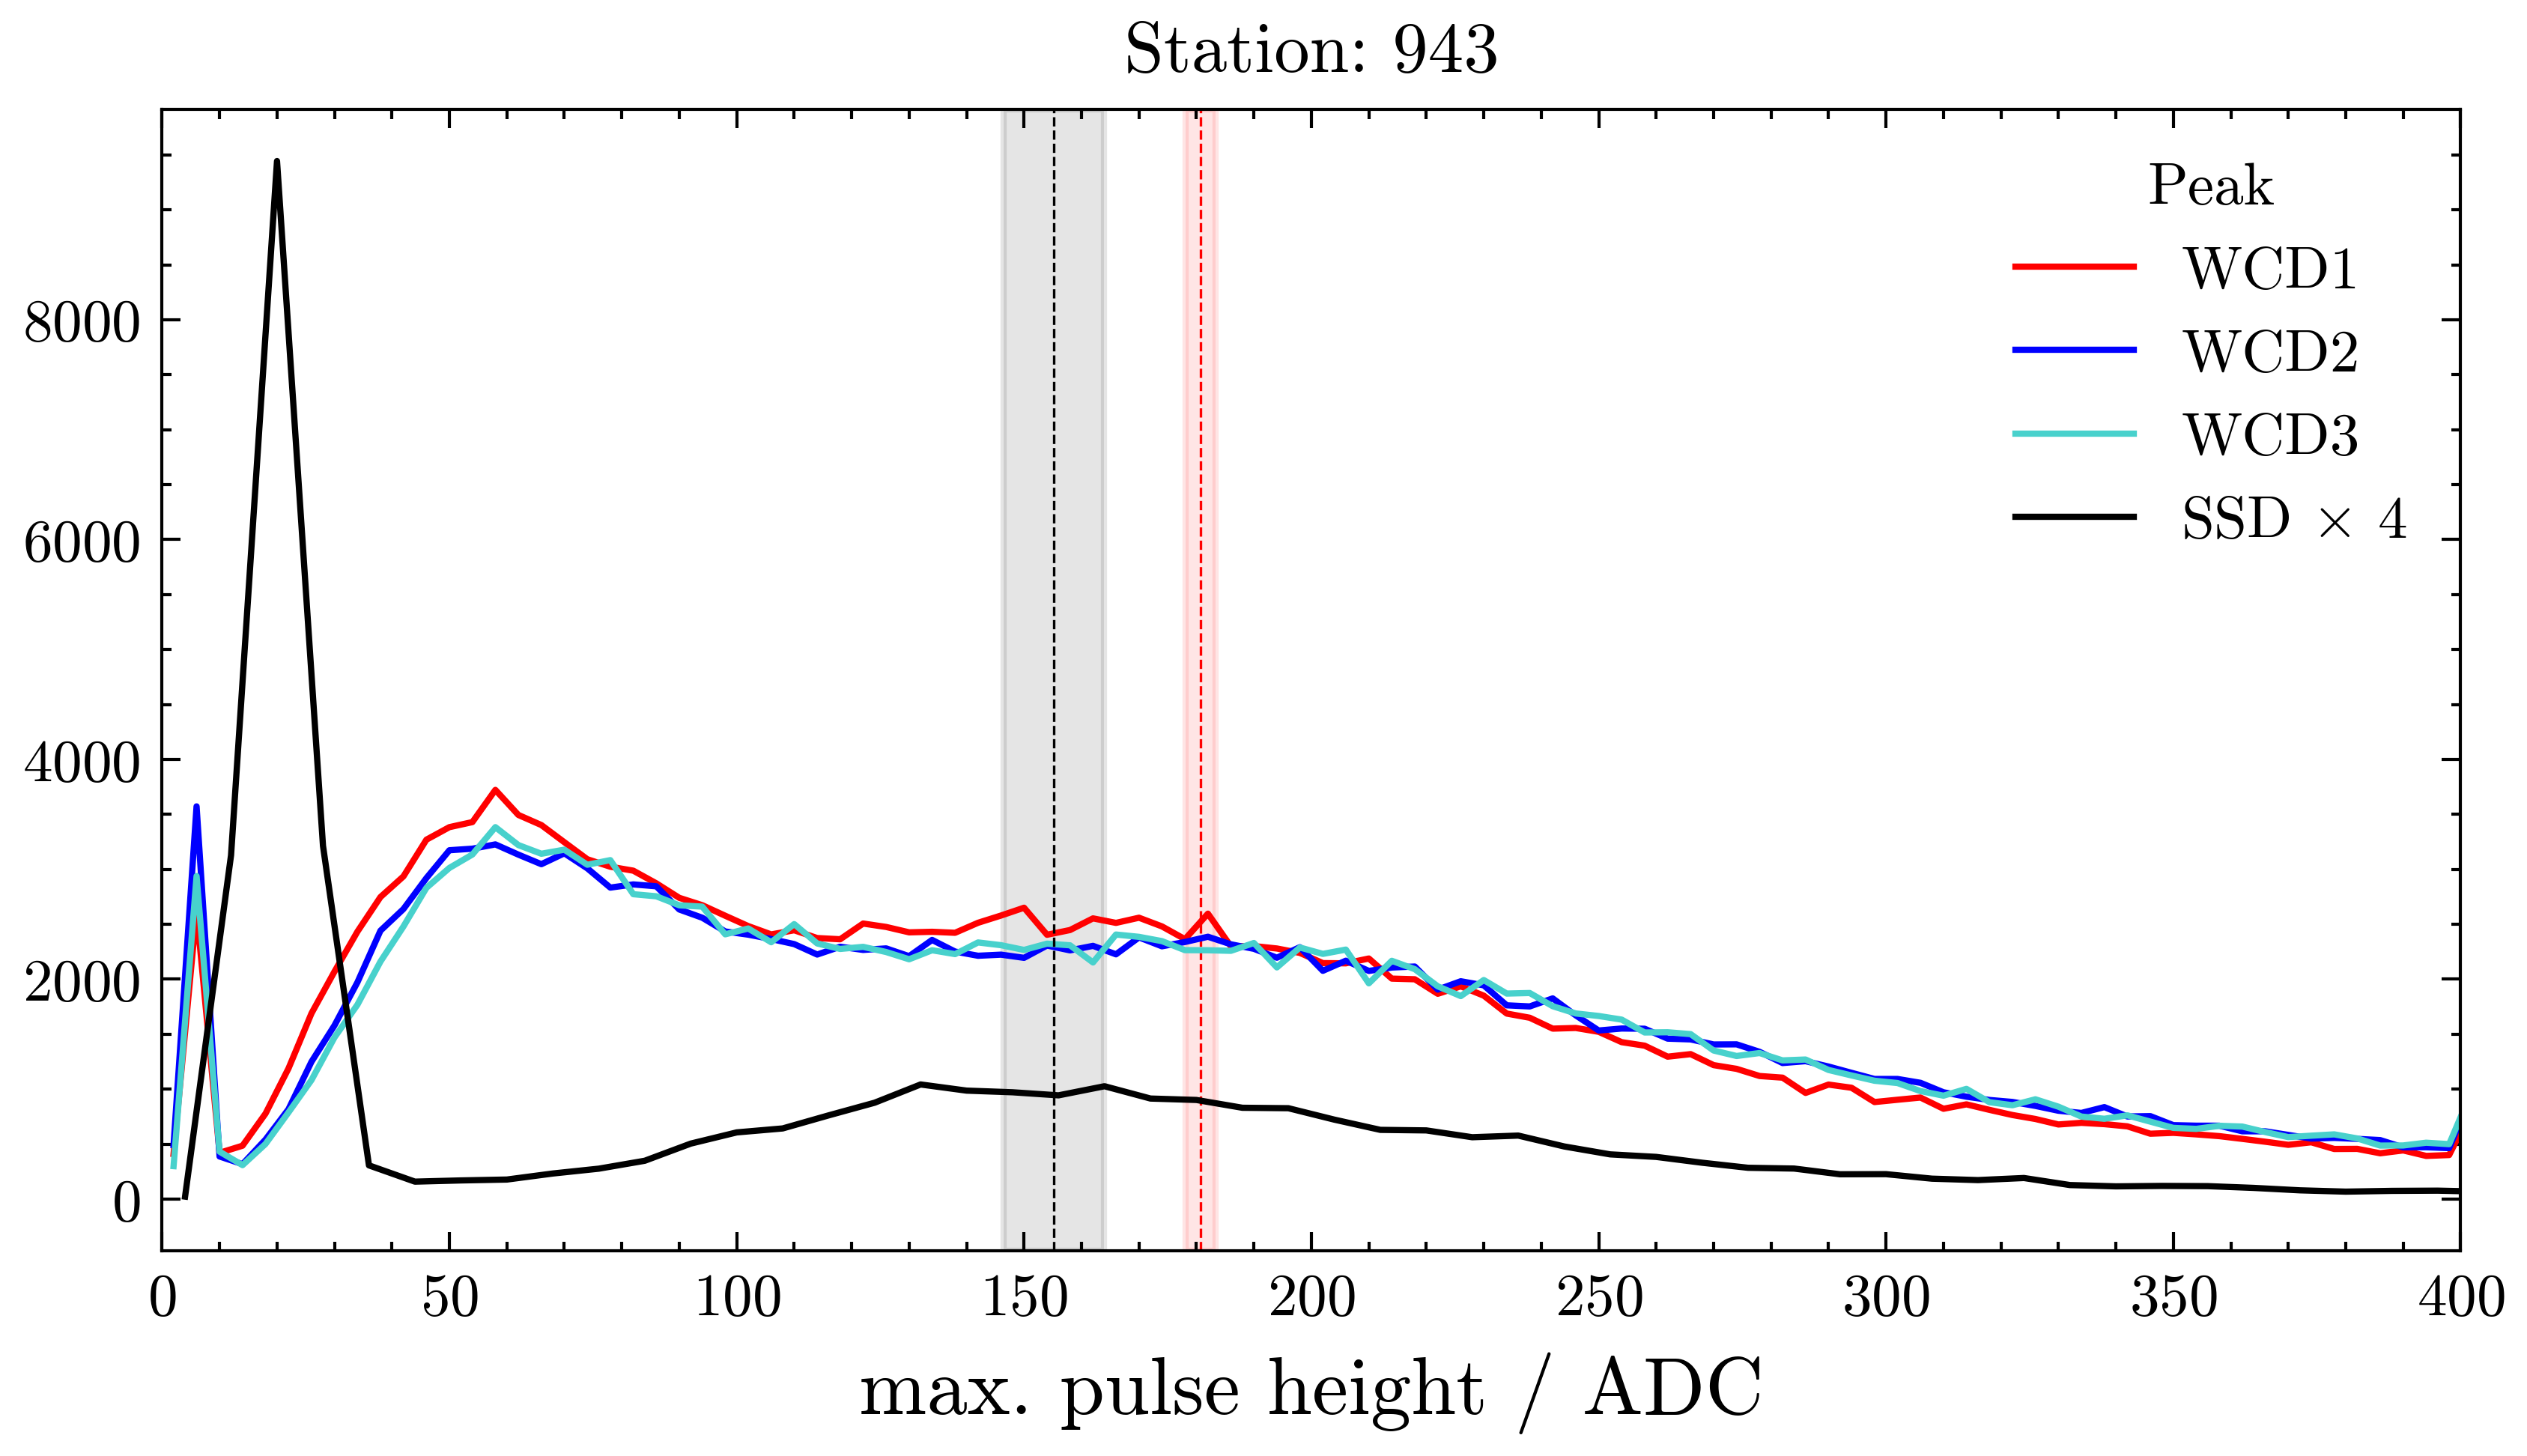

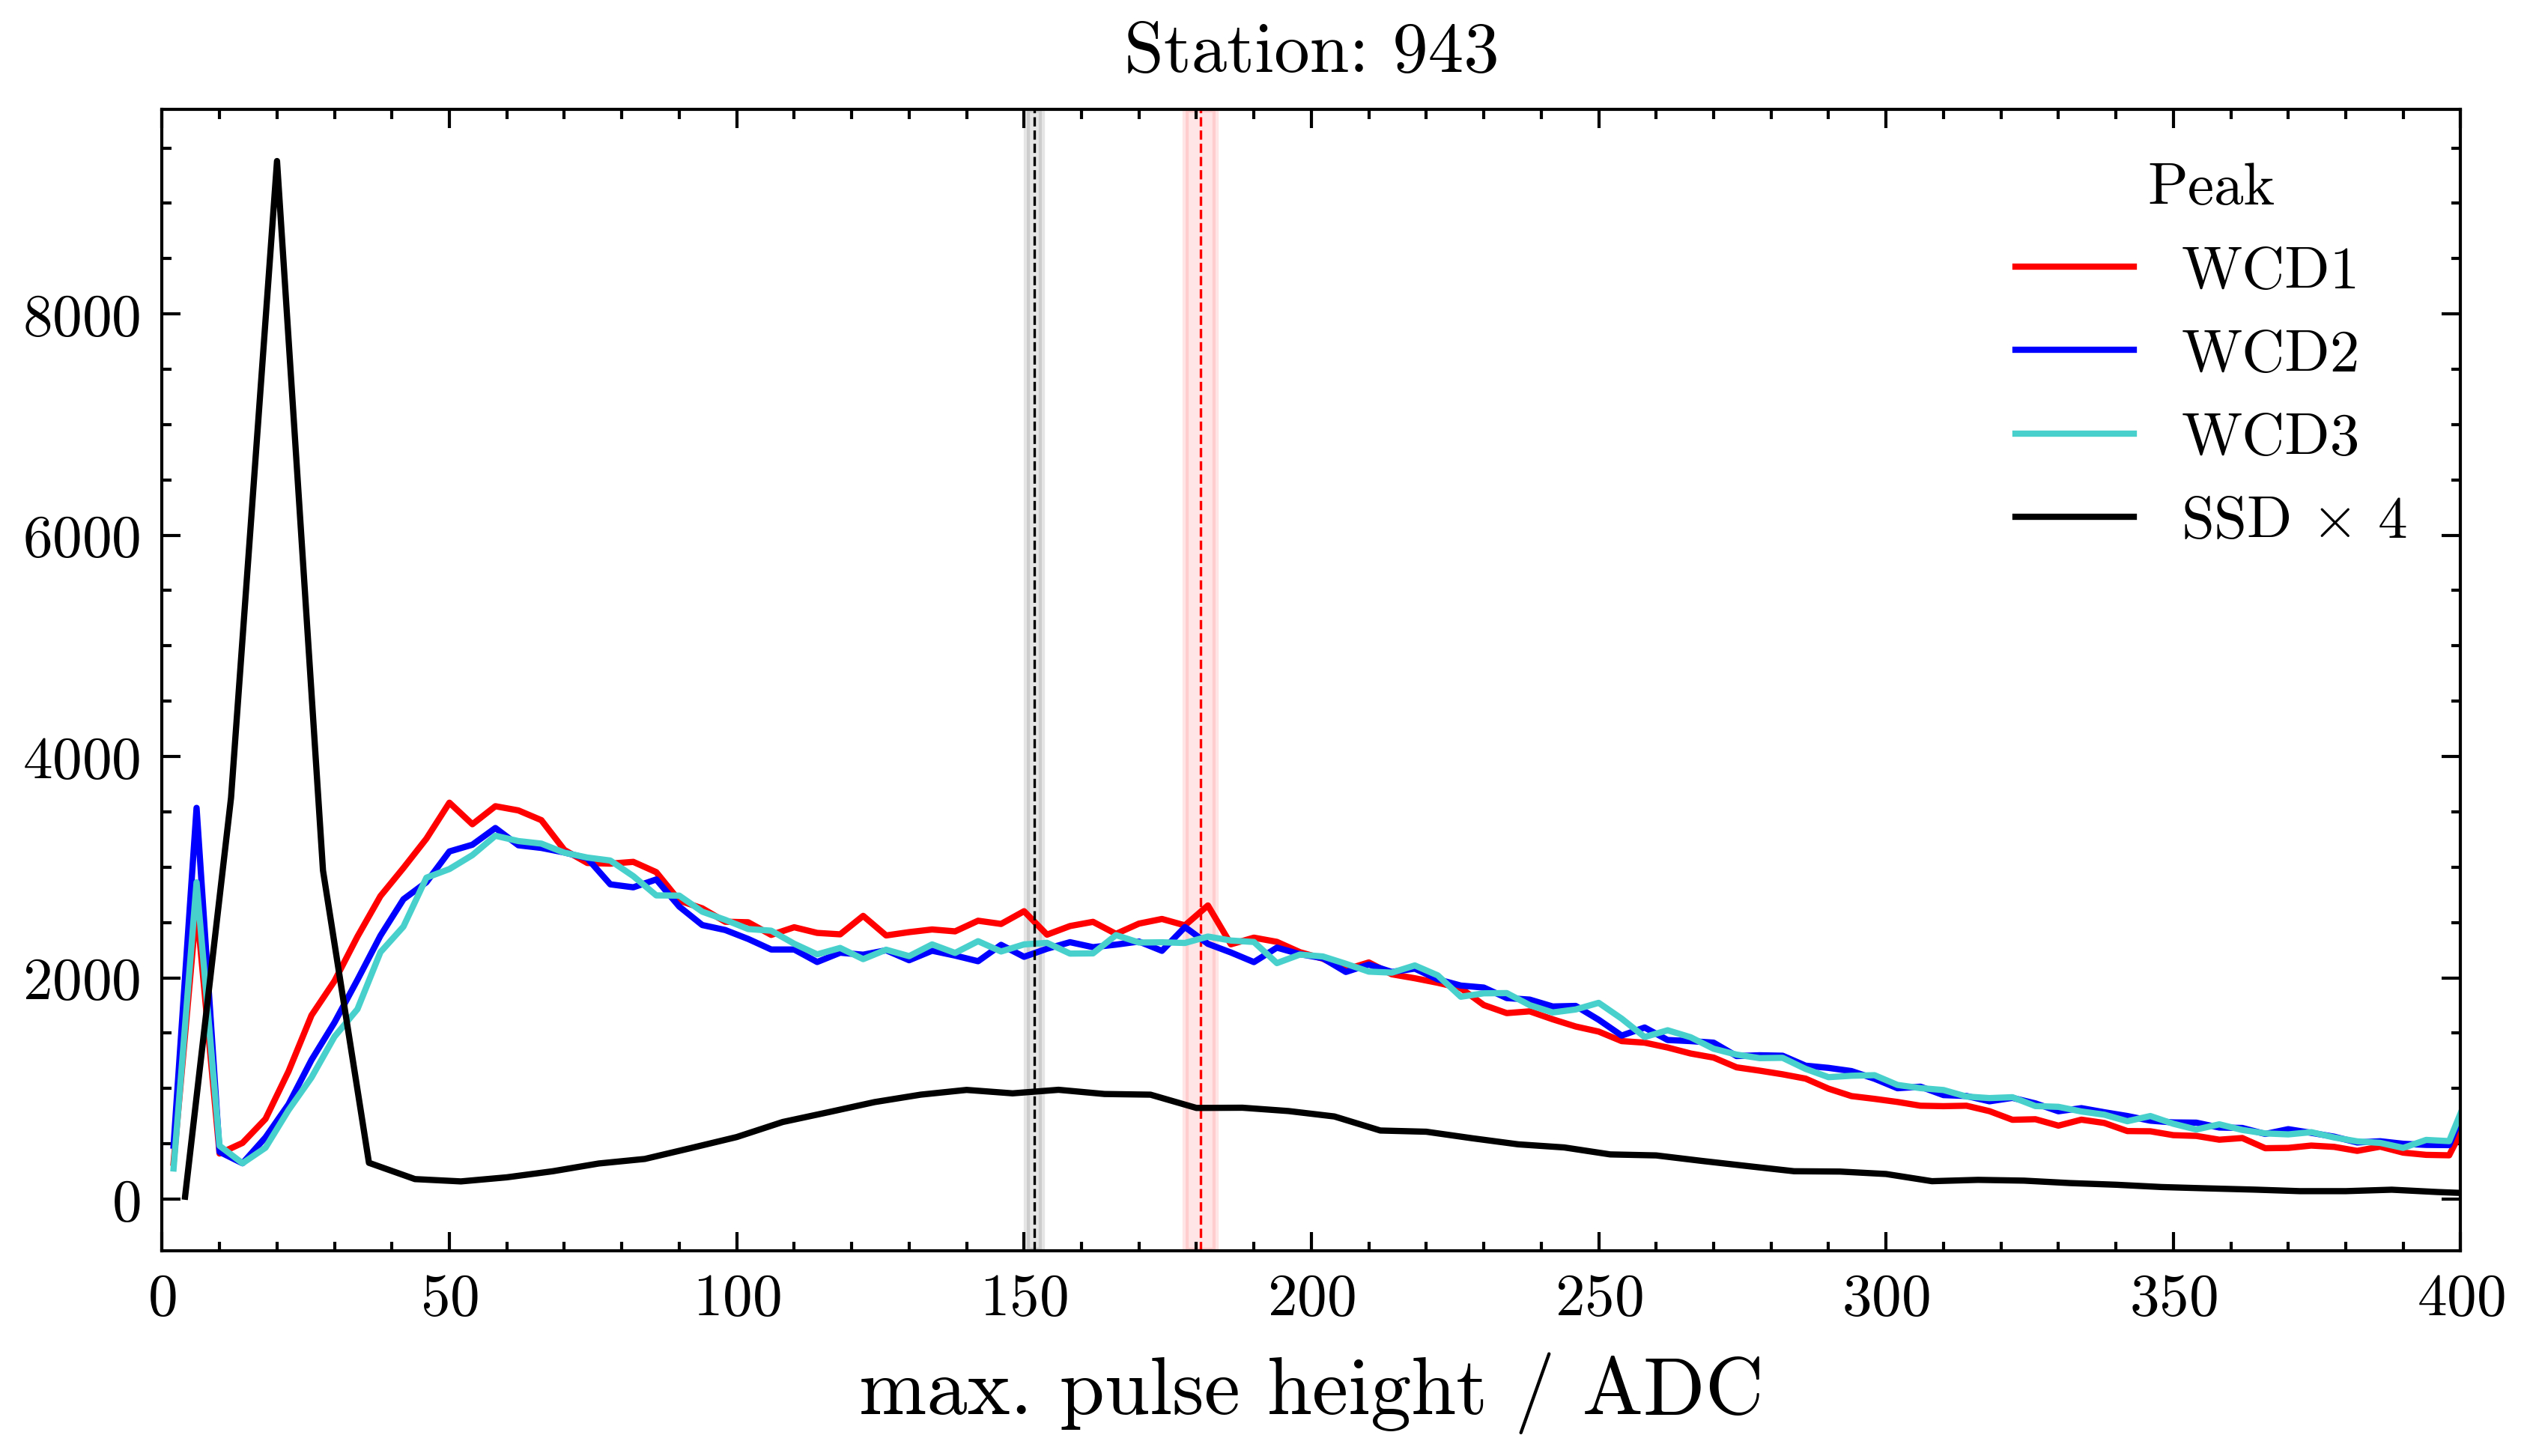

In [3]:
from datetime import datetime

histo_peaks = {
    943: [],
    949: [],
}
histo_timestamps = {
    943: [],
    949: [],
}

# start_ack = datetime.strptime("Dec 06 08:00:27 2024", "%b %d %H:%M:%S %Y").timestamp()  # from IkLog
start_ack = datetime.strptime("Dec 09 15:16:27 2024", "%b %d %H:%M:%S %Y").timestamp()  # from IkLog
data = read_histos('/home/filip/phd-thesis/Projects/SSDOnlineCalib/fitSDHistoFiles/python/peak.txt')

already_seen = []
for event in data:
    if histo_peaks.get(id := event['id'], None) is None: continue
    elif event['timestamp'] < start_ack: continue

    histo = SdHisto(peak=event['data'], pmt_mask=event['pmt_mask'])
    histo_peaks[event['id']].append(histo()['peak'][-1])
    histo_timestamps[event['id']].append(event['timestamp'])

    if event['id'] not in already_seen:
        histo.plot()
        plt.gca().set_title(f"Station: {event['id']}")
        already_seen.append(event['id'])

14:07:35 (  +11.6s) [INFO   ] -- found 375 entries for key fTime and station #943
14:07:35 (   +13ms) [INFO   ] -- found 646 entries for key fTime and station #944
14:07:35 (    +8ms) [INFO   ] -- found 646 entries for key fTime and station #945
14:07:35 (    +9ms) [INFO   ] -- found 647 entries for key fTime and station #948
14:07:35 (    +8ms) [INFO   ] -- found 647 entries for key fTime and station #949
14:07:35 (   +17ms) [INFO   ] -- found 647 entries for key fTime and station #954
14:07:35 (    +9ms) [INFO   ] -- found 647 entries for key fTime and station #972


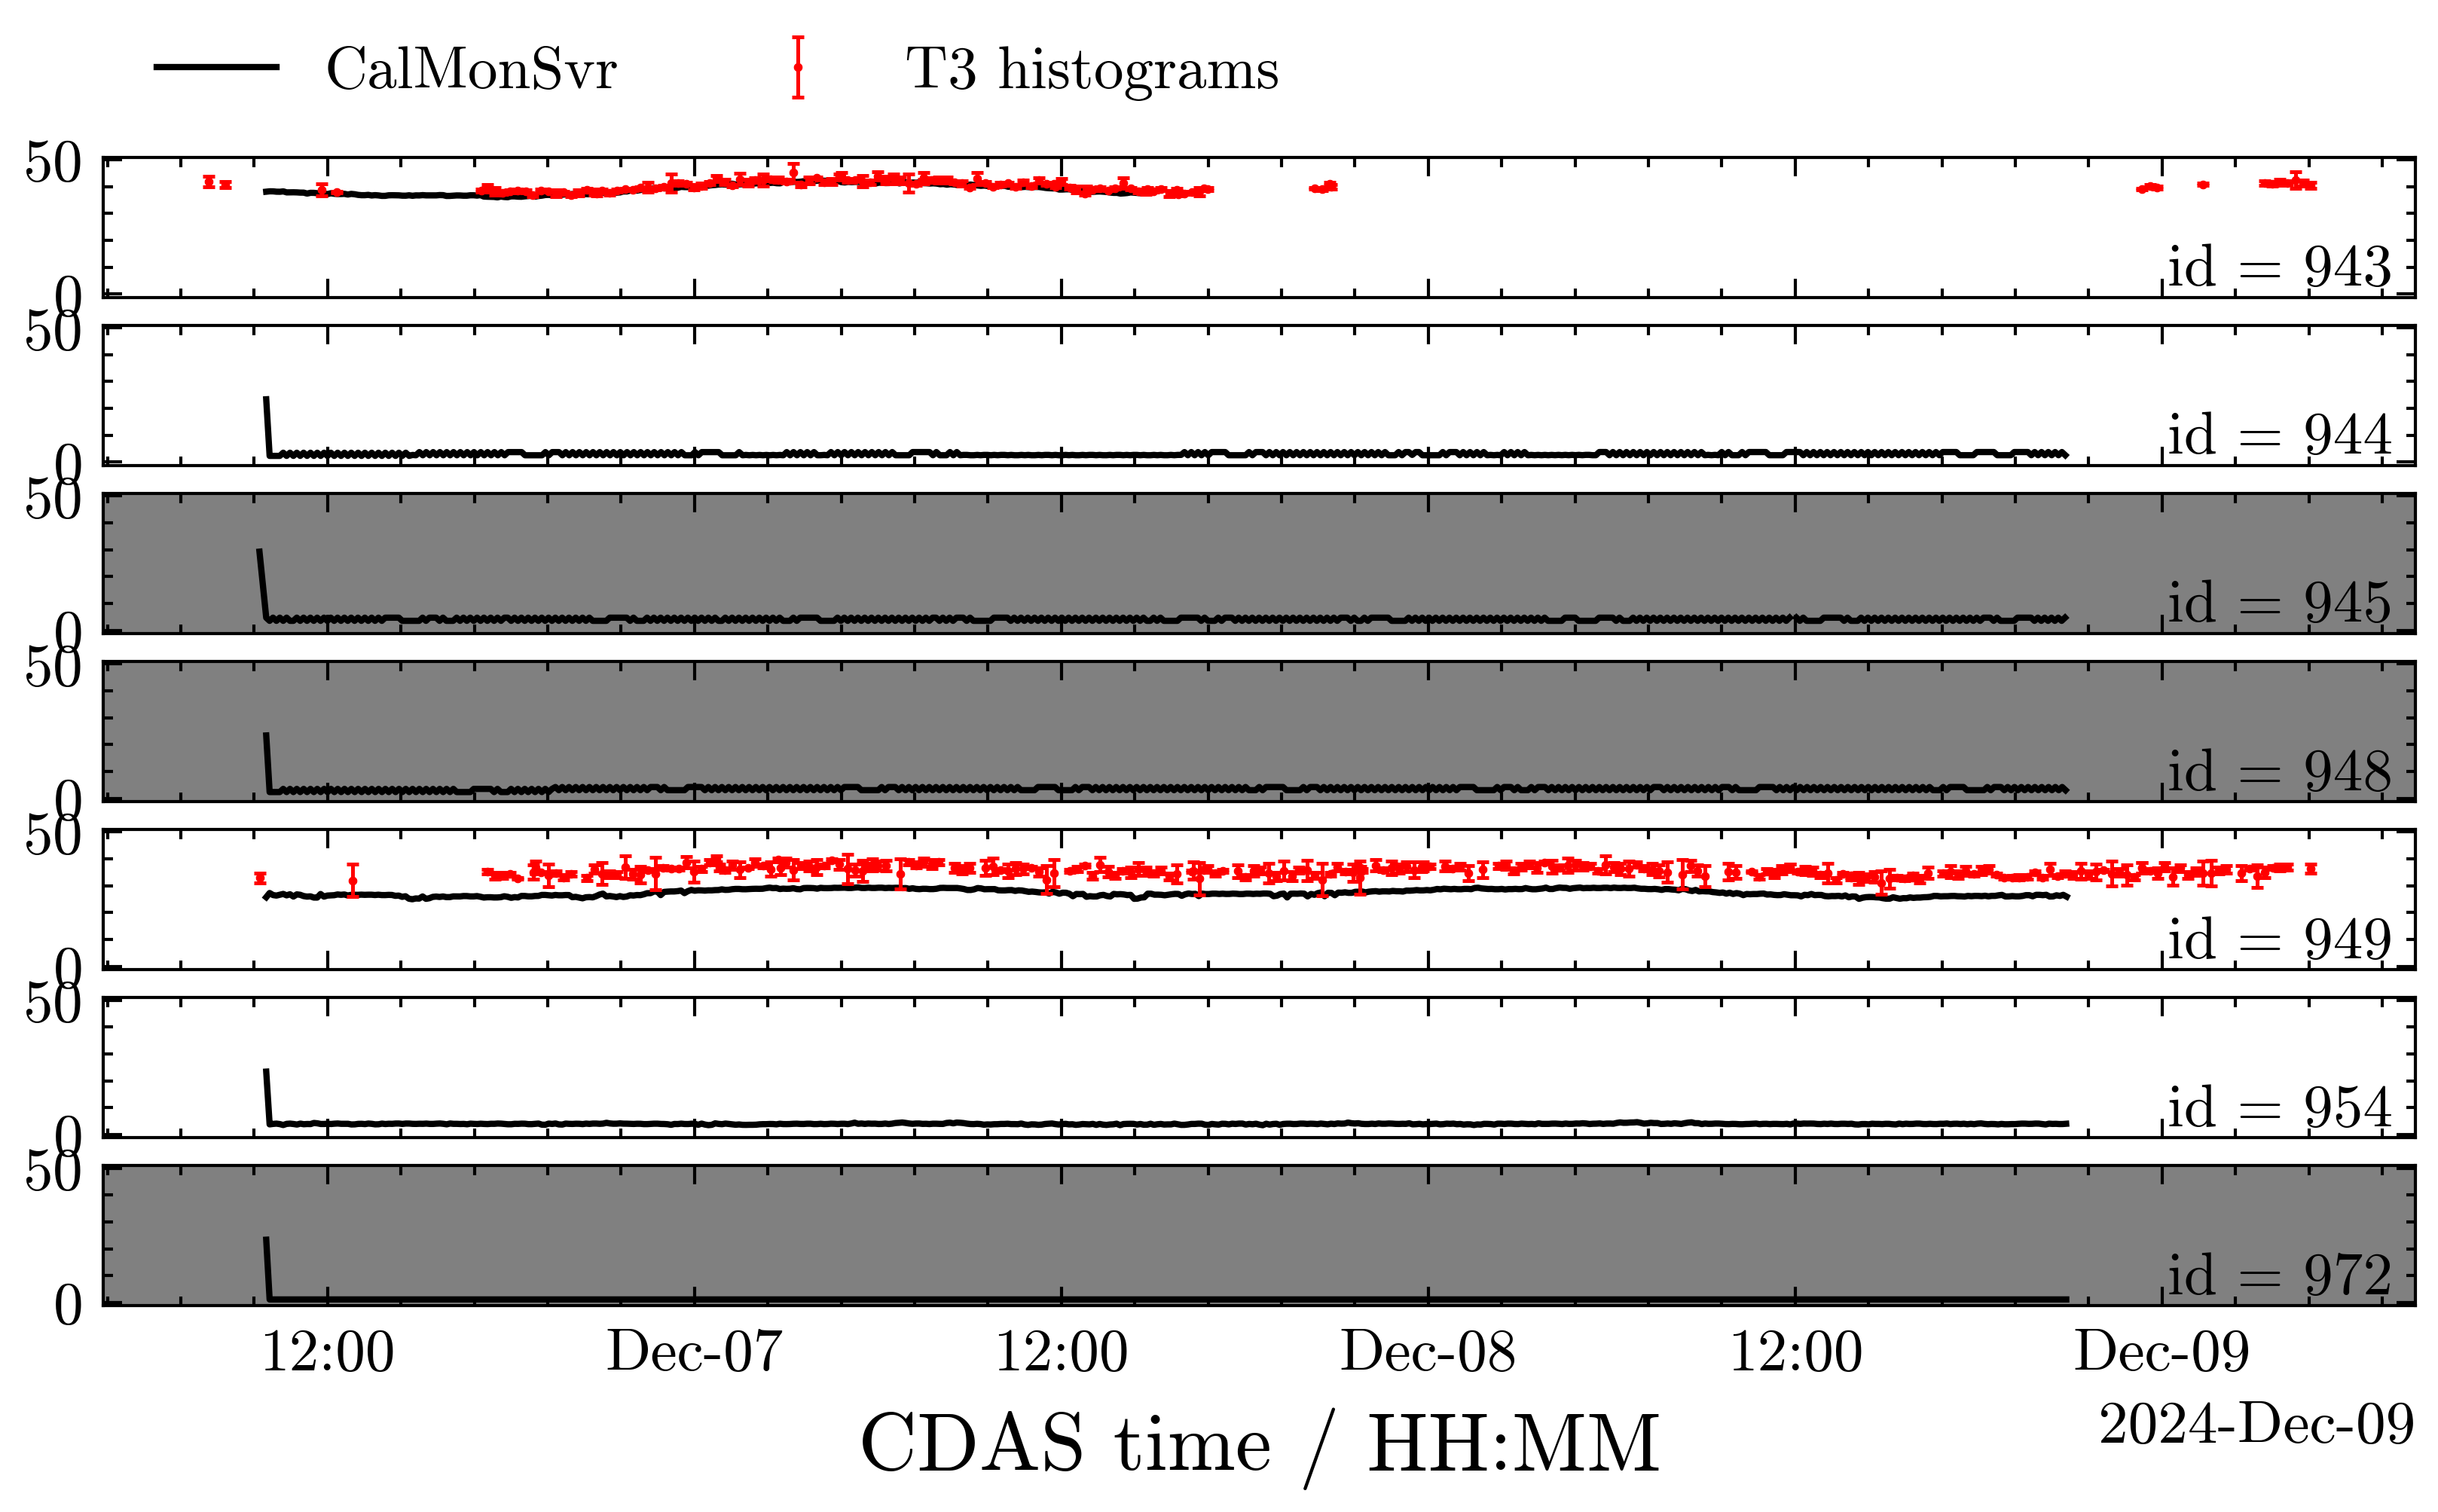

In [4]:
from utils.binaries import *
from utils.plotting import *
import matplotlib.dates as mdates


fig, axes = plt.subplots(7, 1, sharex=True, sharey=True)

LsId = [943, 944, 945, 948, 949, 954, 972]
noSSD = [948, 945, 972]
peaks = {id: [] for id in LsId}

for e in official_daq:
    if e[0] == 136: continue
    elif e[1] is None: 
        peaks[e[0]].append([np.nan for _ in range(4)])
    else:
        peaks[e[0]].append(e[1])

for (id, val), ax in zip(peaks.items(), axes):
    # for i in range(4):
    #    ax.plot(range(len(val)), np.array(val)[:, i], label=i)

    if id in noSSD: ax.set_facecolor('#808080')
    timestamps = monit('fTime', id)
    val = val[:len(timestamps)]
    ax.plot(plot.to_datetime(timestamps), np.array(val)[:, 3], ls='solid', marker='none', label='CalMonSvr')

    ax.text(0.99, 0, f'{id = }', ha='right', va='bottom', transform=ax.transAxes)
    if histo_timestamps.get(id, None) is None: continue

    ax.errorbar(plot.to_datetime(histo_timestamps[id]), [v.n for v in histo_peaks[id]], yerr=[v.std_dev for v in histo_peaks[id]],
                fmt='ro', capsize=1, capthick=0.6, lw=0.6, markersize=0.4, label='T3 histograms')
    
    if id == 943:
        ax.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=2)


locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)

_ = ax.set_xlabel("CDAS time / HH:MM")

14:07:53 (  +17.5s) [INFO   ] -- found 375 entries for key fTime and station #943
14:07:53 (   +25ms) [INFO   ] -- found 647 entries for key fTime and station #949


Text(0.5, 0, 'CalMonSvr time / HH:MM')

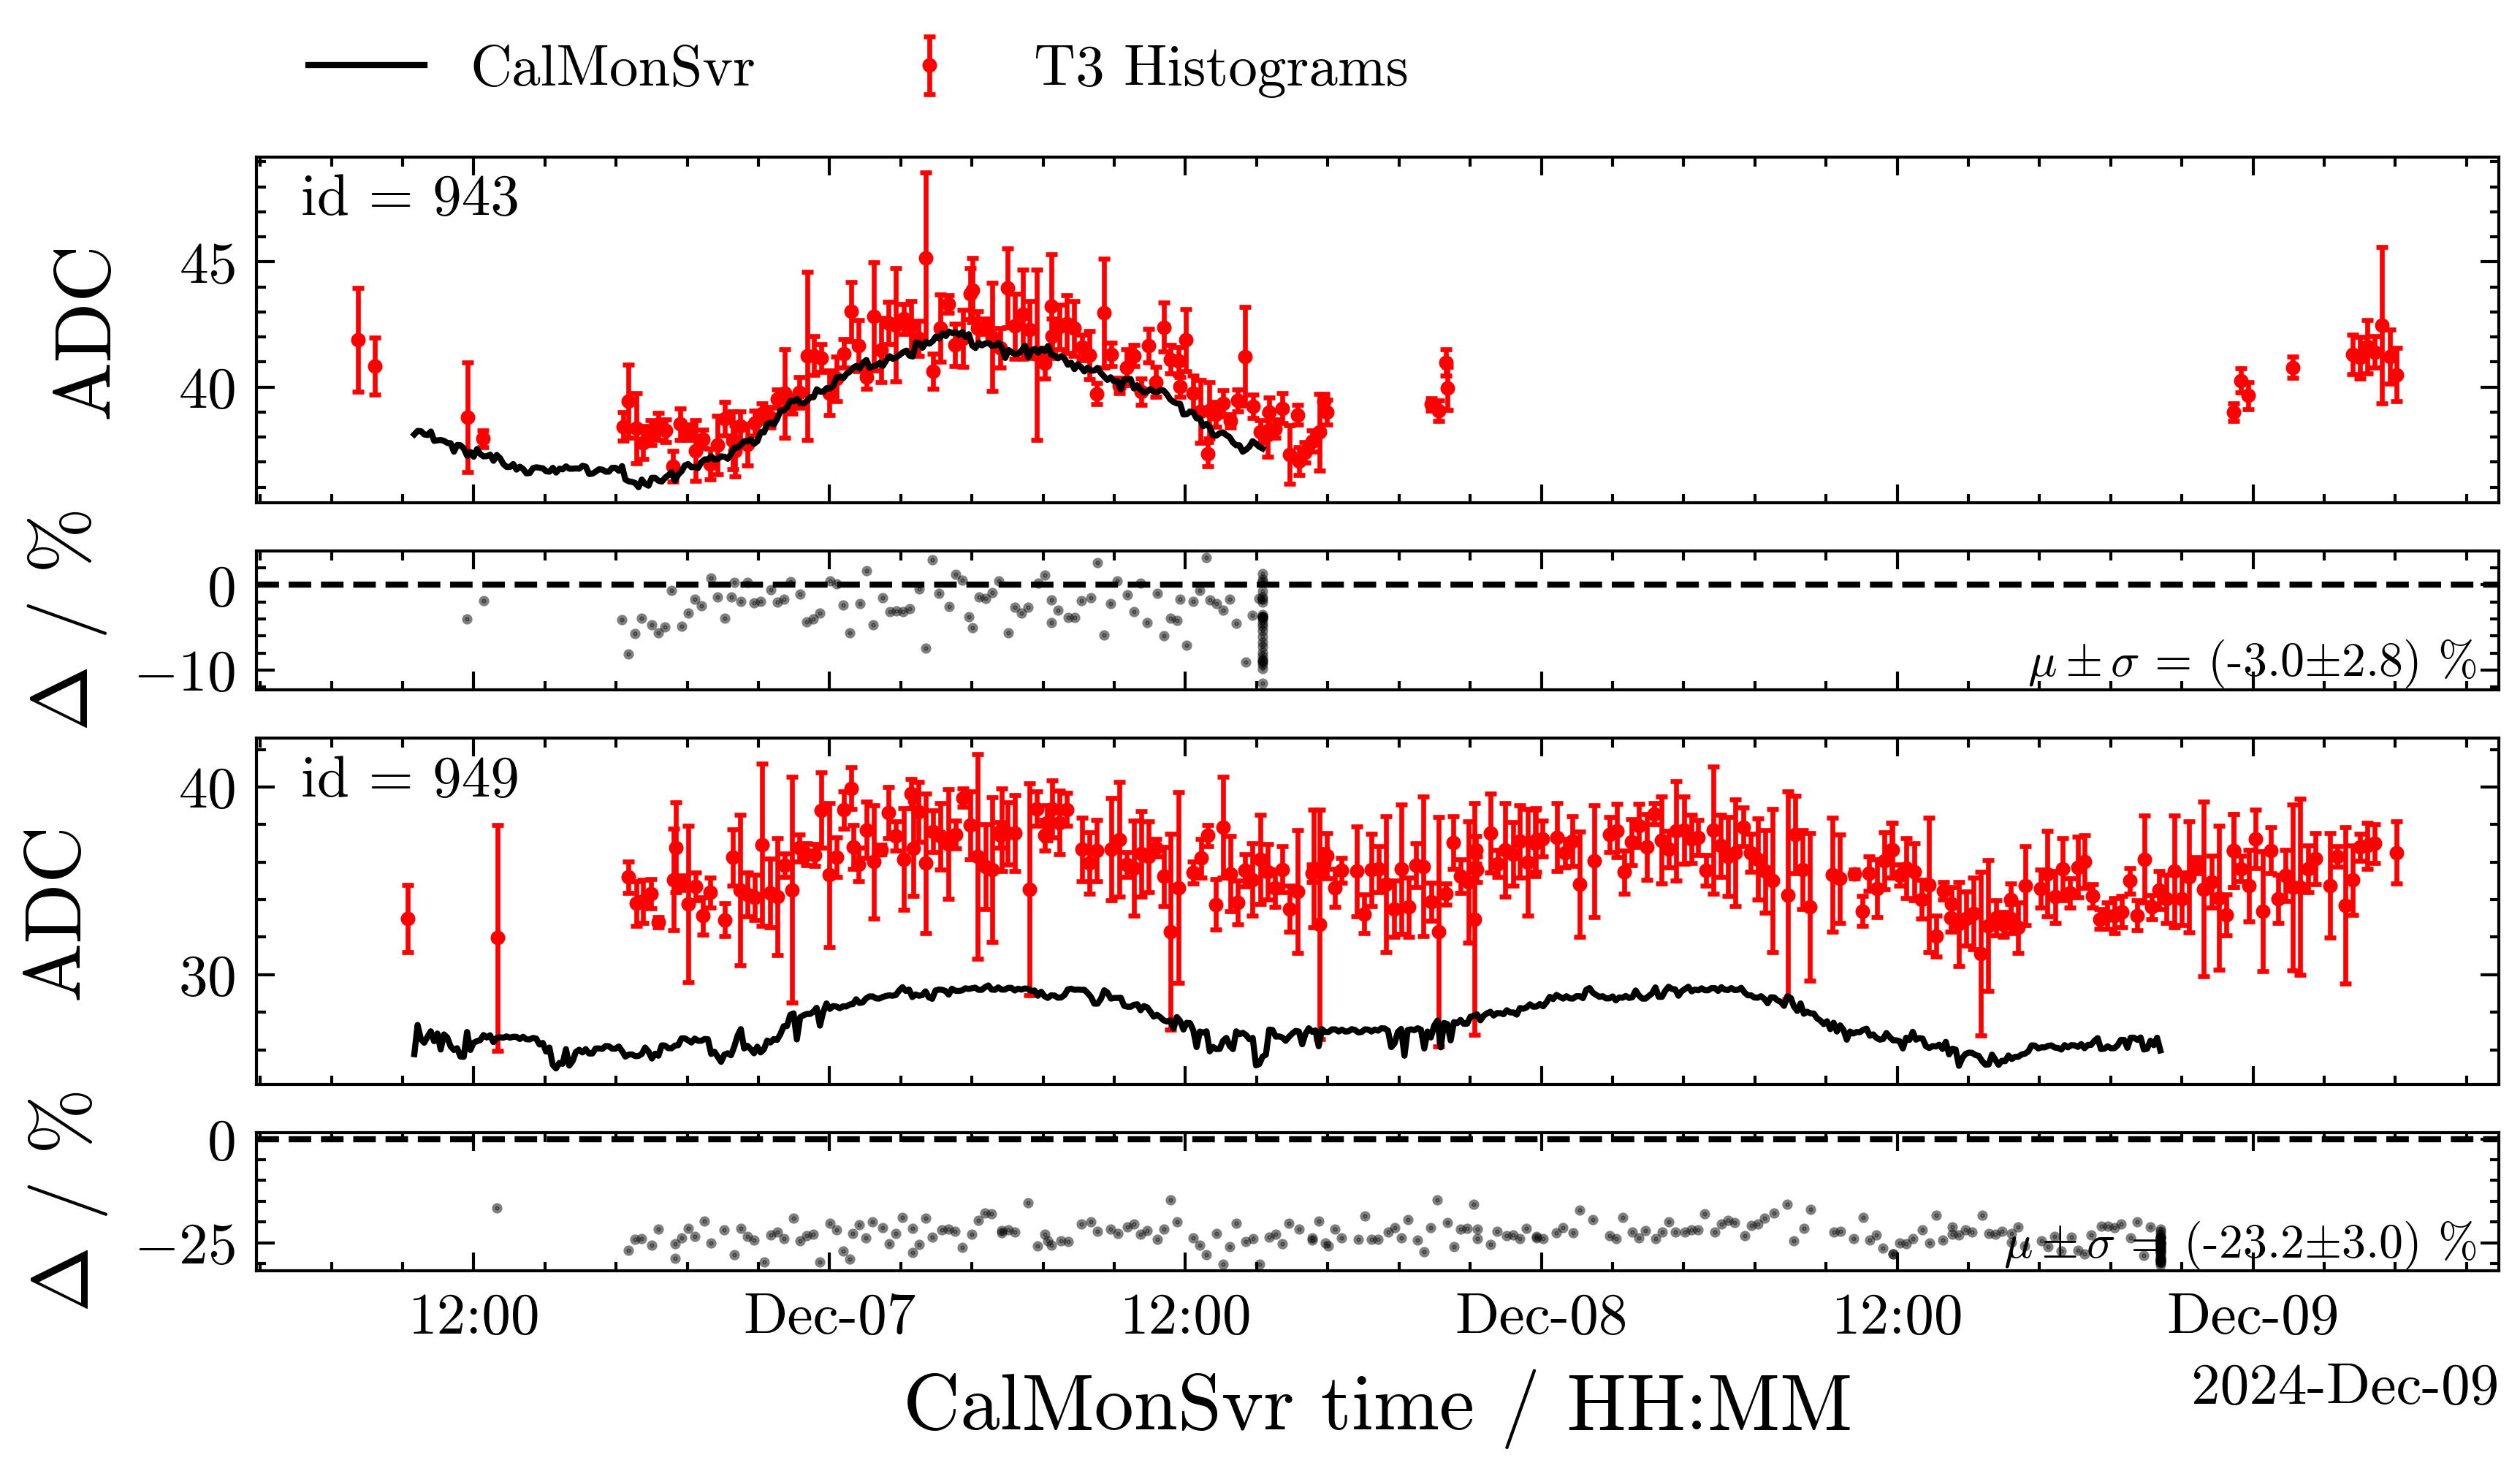

In [6]:
# focus plot for two functioning stations

fig, axes = plt.subplots(4, 1, sharex=True, height_ratios=[1, 0.4, 1, 0.4])

axes = np.split(axes, 2)
ids = [943, 949]

for id, axs in zip([943, 949], axes):
    ax1, ax2 = axs

    calmon_peak = np.array(peaks[id])[:, 3]
    histo_peak = histo_peaks[id]
    histo_time = histo_timestamps[id]
    calmon_time = monit("fTime", id)
    calmon_peak = calmon_peak[:len(calmon_time)]


    ax1.errorbar(plot.to_datetime(histo_time), [v.n for v in histo_peak], yerr=[v.std_dev for v in histo_peak],
                fmt='ro', capsize=1, capthick=0.8, lw=0.8, markersize=1.4, label='T3 Histograms')
    ax1.plot(plot.to_datetime(calmon_time), np.array(calmon_peak), ls='solid', marker='none', zorder=10, label='CalMonSvr')
    
    get_closest_idx = lambda t: np.argmin(np.abs(calmon_time - t))


    diff, timestamps = [], []
    for x, y in zip(histo_time, histo_peak):
        i = get_closest_idx(x)

        if calmon_time[i] - x > 300: continue

        diff.append((calmon_peak[i] - y.n)/y.n)
        timestamps.append(calmon_time[i])

    ax2.scatter(plot.to_datetime(timestamps), np.array(diff)*1e2, alpha=0.5, s=0.5)
    ax2.text(0.99, 0, f"$\mu\pm\sigma$ = ({np.nanmean(diff)*1e2:.1f}$\pm${np.nanstd(diff)*1e2:.1f}) %", 
             ha='right', va='bottom', transform=ax2.transAxes, fontsize='small')
    ax2.axhline(0, c='k', ls='--')

    ax1.set_ylabel('ADC', labelpad=14 if id == 949 else 9)
    ax2.set_ylabel(r'$\Delta$ / %')
    ax1.text(0.02, 0.95, f"{id = }", ha='left', va='top', transform=ax1.transAxes)

    if id == 943:
        ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=2)

plot.apply_datetime_format(ax2)
ax2.set_xlabel('CalMonSvr time / HH:MM')

In [ ]:
# checking ssd histos in stations that have ssd but look wrong

already_seen = []
for i, event in enumerate(data):
    if event['id'] in noSSD or event['id'] in [943, 949] or event['id'] in already_seen: continue

    example_histo = SdHisto(peak = event['data'], pmt_mask=event['pmt_mask'])
    example_histo.fit()
    example_histo.plot()
    plt.gca().set_title(f'Station: {event["id"]}')
    already_seen.append(event['id'])

    # if i > 10: break

In [ ]:
vem_peak = monit('fPeak', 949)
time = monit('fTime', 949)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1,0.4])

for i, c in enumerate(['r', 'b', 'c']):
    calmon_peak = np.array(peaks[949])[:len(time), i]
    ax1.plot(plot.to_datetime(time), vem_peak[:, i], c=c, marker='none', ls=':')
    ax1.plot(plot.to_datetime(time), calmon_peak, c=c, marker='none', ls='solid')

    ax2.plot(plot.to_datetime(time), (calmon_peak - vem_peak[:, i]) / vem_peak[:, i] * 1e2, c=c, ls='-', marker='none')

    print(f"PMT{i}: {np.nanmean((calmon_peak - vem_peak[:, i]) / vem_peak[:, i])}")

fig.suptitle('id = 949')
ax2.axhline(0, c='k', ls='--', lw=0.7)
ax2.set_ylim(-50, 50)
ax1.plot([],[],c="k", ls=":", label='Trigger2', marker='none')
ax1.plot([],[],c="k", ls="-",label='Muonfill', marker='none')
ax1.legend()

ax1.set_ylabel('VEM Peak / ADC')
ax2.set_ylabel('$\Delta$ / %')
ax2.set_xlabel('CalMonSvr time / HH:MM')
plot.apply_datetime_format(ax2)

In [ ]:
vem_peak = monit('fPeak', 943)
time = monit('fTime', 943)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1,0.4])

for i, c in enumerate(['r', 'b', 'c']):
    calmon_peak = np.array(peaks[943])[:len(time), i]
    ax1.plot(plot.to_datetime(time), vem_peak[:, i], c=c, marker='none', ls=':')
    ax1.plot(plot.to_datetime(time), calmon_peak, c=c, marker='none', ls='solid')

    ax2.plot(plot.to_datetime(time), (calmon_peak - vem_peak[:, i]) / vem_peak[:, i] * 1e2, c=c, ls='-', marker='none')

    print(f"PMT{i}: {np.nanmean((calmon_peak - vem_peak[:, i]) / vem_peak[:, i])}")

fig.suptitle('id = 943')
ax2.axhline(0, c='k', ls='--', lw=0.7)
ax2.set_ylim(-2, 2)
ax1.plot([],[],c="k", ls=":", label='Trigger2', marker='none')
ax1.plot([],[],c="k", ls="-",label='Muonfill', marker='none')
ax1.legend()

ax1.set_ylabel('VEM Peak / ADC')
ax2.set_ylabel('$\Delta$ / %')
ax2.set_xlabel('CalMonSvr time / HH:MM')
plot.apply_datetime_format(ax2)

In [ ]:
#      didi   edge      working      broken?
ids = [136] + noSSD + [943, 949] + [944, 954]
test = [0 for _ in ids]

for day in days:
    with open(f'/home/filip/Desktop/unread_packages/monit_2024_12_{day:02}.packs.nobackup', 'rb') as f:
        while f.read(8) == b'!monit!!':
            LsId, data = read_package(f)

            for i, id in enumerate(ids):
                if LsId == id: test[i] += 1

monit = Monit(2024, 12, days)

for i, id in enumerate(ids):
    timestamps = monit('fTime', id)
    print(id, test[i], len(timestamps))